In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.special
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [7]:
def compute_y_from_x(X: np.ndarray):
    return np.cos(X * 10)

def compute_y_from_x_strongnoise(X: np.ndarray, noise_strength):
    y = np.cos(X * 10) # y = cos(25x) + cos(15x) two different frequencies
    noise = np.random.normal(0, 1, y.shape)  # Generate Gaussian noise, with mean 0 and staandard  deviation 1
    y_with_noise = y + noise * noise_strength  # Add Gaussian noise to 'y' values
    return y_with_noise

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)  # Adjust the input and hidden layer sizes as needed
        self.fc2 = nn.Linear(hidden_size, 1)  # Adjust the hidden and output layer sizes as needed

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
num_data = 200
hidden_size_list = np.arange(1, 1001, 10)
learning_rate = 0.001
num_epochs = 1000
test_frac = 0.2
num_repeats = 20  # Number of repeats for each hidden size
noise_strength = 0.2

low, high = -1.0, 1.0

hidden_size_losses = []
param_num_losses = []

for hidden_size in tqdm(hidden_size_list):
    train_losses = []
    test_losses = []
    for repeat_idx in range(num_repeats):
        # Generate input data
        x = np.linspace(low, high, num_data)  # Replace with your desired range and number of points
        #print(repeat_idx)
        # Generate target data
        y = compute_y_from_x_strongnoise(x, noise_strength)

        # Split the data into train and test sets
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_frac)

        # Convert data to PyTorch tensors
        x_train_tensor = torch.from_numpy(x_train).float().unsqueeze(1)
        y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
        x_test_tensor = torch.from_numpy(x_test).float().unsqueeze(1)
        y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

        # Create data loaders
        train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Instantiate the network
        model = NeuralNetwork(hidden_size)
        pytorch_total_params = sum(p.numel() for p in model.parameters())

        # Define the loss function
        criterion = nn.MSELoss()

        # Define the optimizer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        num_epochs = 100  # Adjust the number of epochs as needed

        for epoch in range(num_epochs):
            model.train()  # Set the model in training mode
            train_loss = 0.0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

            train_loss /= len(train_loader.dataset)

            # Evaluate the model on the test set
            model.eval()  # Set the model in evaluation mode
            test_loss = 0.0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    test_loss += loss.item() * inputs.size(0)

            test_loss /= len(test_loader.dataset)

        final_train_loss = train_loss
        final_test_loss = test_loss
        #train_losses.append(final_train_loss)
        #test_losses.append(final_test_loss)

        if repeat_idx == num_repeats - 1:
            print(f"Hidden Size: {hidden_size}, Final Train Loss: {final_train_loss:.4f}, Final Test Loss: {final_test_loss:.4f}")

        hidden_size_losses.append({
            'hidden_size': hidden_size,
            'train_losses': final_train_loss,
            'test_losses': final_test_loss
        })

        param_num_losses.append({
            'param_num': pytorch_total_params,
            'train_losses': final_train_loss,
            'test_losses': final_test_loss
        })


  1%|          | 1/100 [00:22<37:33, 22.76s/it]

Hidden Size: 1, Final Train Loss: 0.6477, Final Test Loss: 0.7597


  2%|▏         | 2/100 [00:47<39:02, 23.90s/it]

Hidden Size: 11, Final Train Loss: 0.5528, Final Test Loss: 0.6504


  3%|▎         | 3/100 [01:10<38:06, 23.57s/it]

Hidden Size: 21, Final Train Loss: 0.5371, Final Test Loss: 0.5478


  4%|▍         | 4/100 [01:30<35:21, 22.10s/it]

Hidden Size: 31, Final Train Loss: 0.4697, Final Test Loss: 0.4204


  5%|▌         | 5/100 [01:51<34:34, 21.84s/it]

Hidden Size: 41, Final Train Loss: 0.5012, Final Test Loss: 0.5056


  6%|▌         | 6/100 [02:22<38:45, 24.73s/it]

Hidden Size: 51, Final Train Loss: 0.4663, Final Test Loss: 0.3791


  7%|▋         | 7/100 [02:45<37:41, 24.32s/it]

Hidden Size: 61, Final Train Loss: 0.4817, Final Test Loss: 0.5097


  8%|▊         | 8/100 [03:08<36:34, 23.86s/it]

Hidden Size: 71, Final Train Loss: 0.4569, Final Test Loss: 0.6766


  9%|▉         | 9/100 [03:29<35:01, 23.10s/it]

Hidden Size: 81, Final Train Loss: 0.4546, Final Test Loss: 0.6125


 10%|█         | 10/100 [03:55<35:39, 23.78s/it]

Hidden Size: 91, Final Train Loss: 0.4622, Final Test Loss: 0.4128


 11%|█         | 11/100 [04:21<36:17, 24.47s/it]

Hidden Size: 101, Final Train Loss: 0.4858, Final Test Loss: 0.5089


 12%|█▏        | 12/100 [04:44<35:07, 23.95s/it]

Hidden Size: 111, Final Train Loss: 0.4524, Final Test Loss: 0.5880


 13%|█▎        | 13/100 [05:07<34:42, 23.93s/it]

Hidden Size: 121, Final Train Loss: 0.4293, Final Test Loss: 0.4595


 14%|█▍        | 14/100 [05:28<32:49, 22.90s/it]

Hidden Size: 131, Final Train Loss: 0.4823, Final Test Loss: 0.3574


 15%|█▌        | 15/100 [05:50<32:13, 22.74s/it]

Hidden Size: 141, Final Train Loss: 0.4200, Final Test Loss: 0.3618


 16%|█▌        | 16/100 [06:13<31:57, 22.83s/it]

Hidden Size: 151, Final Train Loss: 0.4327, Final Test Loss: 0.4686


 17%|█▋        | 17/100 [06:35<30:53, 22.33s/it]

Hidden Size: 161, Final Train Loss: 0.4164, Final Test Loss: 0.4250


 18%|█▊        | 18/100 [06:56<30:09, 22.07s/it]

Hidden Size: 171, Final Train Loss: 0.4120, Final Test Loss: 0.3264


 19%|█▉        | 19/100 [07:17<29:26, 21.81s/it]

Hidden Size: 181, Final Train Loss: 0.3740, Final Test Loss: 0.4723


 20%|██        | 20/100 [07:45<31:31, 23.65s/it]

Hidden Size: 191, Final Train Loss: 0.3797, Final Test Loss: 0.3580


 21%|██        | 21/100 [08:14<33:12, 25.22s/it]

Hidden Size: 201, Final Train Loss: 0.4047, Final Test Loss: 0.4059


 22%|██▏       | 22/100 [08:43<34:03, 26.20s/it]

Hidden Size: 211, Final Train Loss: 0.4034, Final Test Loss: 0.3525


 23%|██▎       | 23/100 [09:12<34:48, 27.13s/it]

Hidden Size: 221, Final Train Loss: 0.3567, Final Test Loss: 0.4617


 24%|██▍       | 24/100 [09:41<35:02, 27.66s/it]

Hidden Size: 231, Final Train Loss: 0.4078, Final Test Loss: 0.4901


 25%|██▌       | 25/100 [10:10<35:10, 28.14s/it]

Hidden Size: 241, Final Train Loss: 0.3603, Final Test Loss: 0.3920


 26%|██▌       | 26/100 [10:38<34:44, 28.17s/it]

Hidden Size: 251, Final Train Loss: 0.4045, Final Test Loss: 0.4137


 27%|██▋       | 27/100 [11:07<34:26, 28.31s/it]

Hidden Size: 261, Final Train Loss: 0.3899, Final Test Loss: 0.4236


 28%|██▊       | 28/100 [11:36<34:13, 28.52s/it]

Hidden Size: 271, Final Train Loss: 0.3214, Final Test Loss: 0.3764


 29%|██▉       | 29/100 [12:28<42:09, 35.62s/it]

Hidden Size: 281, Final Train Loss: 0.3863, Final Test Loss: 0.3622


 30%|███       | 30/100 [13:09<43:23, 37.19s/it]

Hidden Size: 291, Final Train Loss: 0.3710, Final Test Loss: 0.3140


 31%|███       | 31/100 [13:32<37:55, 32.97s/it]

Hidden Size: 301, Final Train Loss: 0.3539, Final Test Loss: 0.3814


 32%|███▏      | 32/100 [14:05<37:15, 32.87s/it]

Hidden Size: 311, Final Train Loss: 0.3355, Final Test Loss: 0.3116


 33%|███▎      | 33/100 [14:33<35:18, 31.62s/it]

Hidden Size: 321, Final Train Loss: 0.3442, Final Test Loss: 0.3280


 34%|███▍      | 34/100 [14:59<32:55, 29.94s/it]

Hidden Size: 331, Final Train Loss: 0.3601, Final Test Loss: 0.3504


 35%|███▌      | 35/100 [15:23<30:22, 28.04s/it]

Hidden Size: 341, Final Train Loss: 0.3311, Final Test Loss: 0.2709


 36%|███▌      | 36/100 [15:46<28:26, 26.66s/it]

Hidden Size: 351, Final Train Loss: 0.3235, Final Test Loss: 0.3875


 37%|███▋      | 37/100 [16:16<28:57, 27.57s/it]

Hidden Size: 361, Final Train Loss: 0.2801, Final Test Loss: 0.3522


 38%|███▊      | 38/100 [16:42<28:02, 27.14s/it]

Hidden Size: 371, Final Train Loss: 0.2978, Final Test Loss: 0.2973


 39%|███▉      | 39/100 [17:07<26:42, 26.26s/it]

Hidden Size: 381, Final Train Loss: 0.3175, Final Test Loss: 0.3407


 40%|████      | 40/100 [17:30<25:33, 25.56s/it]

Hidden Size: 391, Final Train Loss: 0.3146, Final Test Loss: 0.3532


 41%|████      | 41/100 [18:00<26:16, 26.73s/it]

Hidden Size: 401, Final Train Loss: 0.3180, Final Test Loss: 0.4992


 42%|████▏     | 42/100 [18:26<25:33, 26.43s/it]

Hidden Size: 411, Final Train Loss: 0.3023, Final Test Loss: 0.3784


 43%|████▎     | 43/100 [19:12<30:45, 32.38s/it]

Hidden Size: 421, Final Train Loss: 0.3169, Final Test Loss: 0.4137


 44%|████▍     | 44/100 [19:51<32:06, 34.41s/it]

Hidden Size: 431, Final Train Loss: 0.2651, Final Test Loss: 0.4516


 45%|████▌     | 45/100 [20:16<28:58, 31.62s/it]

Hidden Size: 441, Final Train Loss: 0.3175, Final Test Loss: 0.3669


 46%|████▌     | 46/100 [20:42<26:55, 29.91s/it]

Hidden Size: 451, Final Train Loss: 0.2990, Final Test Loss: 0.3262


 47%|████▋     | 47/100 [21:06<24:52, 28.16s/it]

Hidden Size: 461, Final Train Loss: 0.2887, Final Test Loss: 0.1799


 48%|████▊     | 48/100 [21:34<24:26, 28.20s/it]

Hidden Size: 471, Final Train Loss: 0.3068, Final Test Loss: 0.3728


 49%|████▉     | 49/100 [21:59<23:07, 27.20s/it]

Hidden Size: 481, Final Train Loss: 0.3468, Final Test Loss: 0.2695


 50%|█████     | 50/100 [22:22<21:33, 25.86s/it]

Hidden Size: 491, Final Train Loss: 0.2922, Final Test Loss: 0.2835


 51%|█████     | 51/100 [22:55<22:52, 28.00s/it]

Hidden Size: 501, Final Train Loss: 0.2825, Final Test Loss: 0.2971


 52%|█████▏    | 52/100 [23:25<22:49, 28.53s/it]

Hidden Size: 511, Final Train Loss: 0.3256, Final Test Loss: 0.2739


 53%|█████▎    | 53/100 [23:50<21:37, 27.61s/it]

Hidden Size: 521, Final Train Loss: 0.2609, Final Test Loss: 0.3102


 54%|█████▍    | 54/100 [24:14<20:14, 26.39s/it]

Hidden Size: 531, Final Train Loss: 0.3302, Final Test Loss: 0.2744


 55%|█████▌    | 55/100 [24:40<19:41, 26.25s/it]

Hidden Size: 541, Final Train Loss: 0.2558, Final Test Loss: 0.3411


 56%|█████▌    | 56/100 [25:03<18:36, 25.37s/it]

Hidden Size: 551, Final Train Loss: 0.3134, Final Test Loss: 0.3446


 57%|█████▋    | 57/100 [25:27<17:54, 24.99s/it]

Hidden Size: 561, Final Train Loss: 0.3048, Final Test Loss: 0.2518


 58%|█████▊    | 58/100 [25:50<17:05, 24.41s/it]

Hidden Size: 571, Final Train Loss: 0.2861, Final Test Loss: 0.3258


 59%|█████▉    | 59/100 [26:14<16:32, 24.22s/it]

Hidden Size: 581, Final Train Loss: 0.3046, Final Test Loss: 0.3611


 60%|██████    | 60/100 [15:08:40<176:40:32, 15900.81s/it]

Hidden Size: 591, Final Train Loss: 0.2818, Final Test Loss: 0.2402


 61%|██████    | 61/100 [15:10:12<120:52:48, 11158.16s/it]

Hidden Size: 601, Final Train Loss: 0.3181, Final Test Loss: 0.2439


 62%|██████▏   | 62/100 [15:10:53<82:34:29, 7822.89s/it]  

Hidden Size: 611, Final Train Loss: 0.2773, Final Test Loss: 0.2933


 63%|██████▎   | 63/100 [15:11:20<56:21:59, 5484.30s/it]

Hidden Size: 621, Final Train Loss: 0.2627, Final Test Loss: 0.2968


 64%|██████▍   | 64/100 [15:11:47<38:28:09, 3846.94s/it]

Hidden Size: 631, Final Train Loss: 0.2682, Final Test Loss: 0.3138


 65%|██████▌   | 65/100 [15:12:13<26:15:21, 2700.61s/it]

Hidden Size: 641, Final Train Loss: 0.2603, Final Test Loss: 0.3150


 66%|██████▌   | 66/100 [15:12:53<17:58:02, 1902.42s/it]

Hidden Size: 651, Final Train Loss: 0.2802, Final Test Loss: 0.3805


 67%|██████▋   | 67/100 [15:13:25<12:17:46, 1341.40s/it]

Hidden Size: 661, Final Train Loss: 0.2808, Final Test Loss: 0.2596


 68%|██████▊   | 68/100 [15:13:51<8:24:57, 946.79s/it]  

Hidden Size: 671, Final Train Loss: 0.2585, Final Test Loss: 0.2974


 69%|██████▉   | 69/100 [15:14:48<5:51:17, 679.91s/it]

Hidden Size: 681, Final Train Loss: 0.2491, Final Test Loss: 0.2893


 70%|███████   | 70/100 [15:15:22<4:03:05, 486.20s/it]

Hidden Size: 691, Final Train Loss: 0.2328, Final Test Loss: 0.2716


 71%|███████   | 71/100 [15:15:53<2:49:00, 349.68s/it]

Hidden Size: 701, Final Train Loss: 0.2569, Final Test Loss: 0.2472


 72%|███████▏  | 72/100 [15:17:08<2:04:38, 267.08s/it]

Hidden Size: 711, Final Train Loss: 0.2693, Final Test Loss: 0.3226


 73%|███████▎  | 73/100 [15:17:46<1:29:20, 198.52s/it]

Hidden Size: 721, Final Train Loss: 0.2590, Final Test Loss: 0.2903


 74%|███████▍  | 74/100 [15:23:47<1:47:02, 247.02s/it]

Hidden Size: 731, Final Train Loss: 0.2554, Final Test Loss: 0.3678


 75%|███████▌  | 75/100 [15:24:47<1:19:33, 190.92s/it]

Hidden Size: 741, Final Train Loss: 0.2590, Final Test Loss: 0.2585


 76%|███████▌  | 76/100 [15:25:24<57:57, 144.90s/it]  

Hidden Size: 751, Final Train Loss: 0.2795, Final Test Loss: 0.2304


 77%|███████▋  | 77/100 [15:25:56<42:35, 111.10s/it]

Hidden Size: 761, Final Train Loss: 0.2358, Final Test Loss: 0.2892


 78%|███████▊  | 78/100 [15:26:28<31:59, 87.23s/it] 

Hidden Size: 771, Final Train Loss: 0.2497, Final Test Loss: 0.2435


 79%|███████▉  | 79/100 [15:26:57<24:24, 69.74s/it]

Hidden Size: 781, Final Train Loss: 0.2613, Final Test Loss: 0.2149


 80%|████████  | 80/100 [15:27:22<18:48, 56.41s/it]

Hidden Size: 791, Final Train Loss: 0.2720, Final Test Loss: 0.3056


 81%|████████  | 81/100 [15:27:55<15:36, 49.31s/it]

Hidden Size: 801, Final Train Loss: 0.2608, Final Test Loss: 0.2015


 82%|████████▏ | 82/100 [15:28:24<12:56, 43.17s/it]

Hidden Size: 811, Final Train Loss: 0.2395, Final Test Loss: 0.2309


 83%|████████▎ | 83/100 [15:28:52<11:00, 38.83s/it]

Hidden Size: 821, Final Train Loss: 0.2576, Final Test Loss: 0.1633


 84%|████████▍ | 84/100 [15:29:18<09:18, 34.89s/it]

Hidden Size: 831, Final Train Loss: 0.2315, Final Test Loss: 0.2406


 85%|████████▌ | 85/100 [15:29:48<08:22, 33.51s/it]

Hidden Size: 841, Final Train Loss: 0.2604, Final Test Loss: 0.2105


 86%|████████▌ | 86/100 [15:30:53<10:00, 42.86s/it]

Hidden Size: 851, Final Train Loss: 0.2528, Final Test Loss: 0.3209


 87%|████████▋ | 87/100 [15:31:20<08:16, 38.16s/it]

Hidden Size: 861, Final Train Loss: 0.2365, Final Test Loss: 0.2545


 88%|████████▊ | 88/100 [15:31:51<07:10, 35.88s/it]

Hidden Size: 871, Final Train Loss: 0.2138, Final Test Loss: 0.3130


 89%|████████▉ | 89/100 [15:32:20<06:12, 33.86s/it]

Hidden Size: 881, Final Train Loss: 0.2279, Final Test Loss: 0.2604


 90%|█████████ | 90/100 [15:32:50<05:26, 32.65s/it]

Hidden Size: 891, Final Train Loss: 0.2364, Final Test Loss: 0.1841


 91%|█████████ | 91/100 [15:33:21<04:50, 32.33s/it]

Hidden Size: 901, Final Train Loss: 0.2544, Final Test Loss: 0.2790


 92%|█████████▏| 92/100 [15:33:48<04:05, 30.71s/it]

Hidden Size: 911, Final Train Loss: 0.2373, Final Test Loss: 0.2168


 93%|█████████▎| 93/100 [15:34:16<03:28, 29.77s/it]

Hidden Size: 921, Final Train Loss: 0.2592, Final Test Loss: 0.2326


 94%|█████████▍| 94/100 [15:34:47<03:00, 30.07s/it]

Hidden Size: 931, Final Train Loss: 0.2095, Final Test Loss: 0.3914


 95%|█████████▌| 95/100 [15:35:12<02:23, 28.70s/it]

Hidden Size: 941, Final Train Loss: 0.2300, Final Test Loss: 0.2238


 96%|█████████▌| 96/100 [15:35:39<01:52, 28.07s/it]

Hidden Size: 951, Final Train Loss: 0.2426, Final Test Loss: 0.2833


 97%|█████████▋| 97/100 [15:36:10<01:27, 29.15s/it]

Hidden Size: 961, Final Train Loss: 0.2375, Final Test Loss: 0.2921


 98%|█████████▊| 98/100 [15:36:40<00:58, 29.23s/it]

Hidden Size: 971, Final Train Loss: 0.2316, Final Test Loss: 0.2364


 99%|█████████▉| 99/100 [15:37:06<00:28, 28.36s/it]

Hidden Size: 981, Final Train Loss: 0.2106, Final Test Loss: 0.2972


100%|██████████| 100/100 [15:37:32<00:00, 562.52s/it]

Hidden Size: 991, Final Train Loss: 0.2201, Final Test Loss: 0.3087


C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

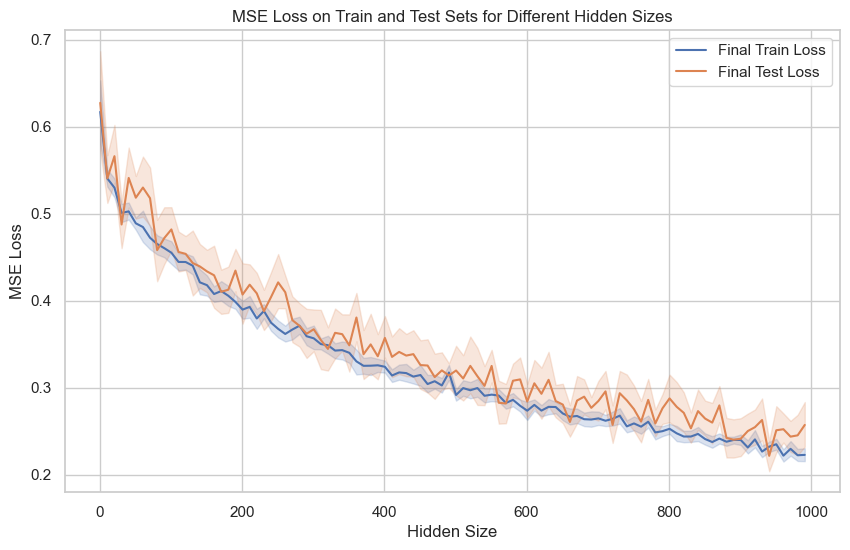

In [17]:
df = pd.DataFrame(hidden_size_losses)

# Plot the losses using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="hidden_size", y="train_losses", label="Final Train Loss")
sns.lineplot(data=df, x="hidden_size", y="test_losses", label="Final Test Loss")
plt.title("MSE Loss on Train and Test Sets for Different Hidden Sizes")
plt.xlabel("Hidden Size")
plt.ylabel("MSE Loss")
plt.savefig("NN_trained_on_cosine_noise_2.svg", format="svg")
plt.show()